In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from prophet import Prophet

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

Importing plotly failed. Interactive plots will not work.


In [47]:
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

## Prophet Model on Time Series Data

Model takes roughly 10 minutes to run on the entire set of data!

**Goals of the notebook**:
1. Create a Prophet model that can handle 5 minute data
2. Understand how to evaluate the quality of the model, and visualize its performance
3. Understand how prophet works under the hood, and what sort of function is being used to represent our data.

In [65]:
raw_data = pd.read_csv("../data-files/CAISO_data.csv")
data = raw_data.drop("Unnamed: 0", axis=1)
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.tz_convert('US/Pacific').dt.tz_localize(None)
data = data.rename({'timestamp': 'ds'}, axis=1)
data = data.rename({'load_MW': 'y'}, axis=1)
data = data[['ds', 'y']].sort_values('ds', ascending=True)
data.head()

,ds,y
171,2015-01-01 00:00:00,23041.0
55,2015-01-01 00:05:00,22937.0
77,2015-01-01 00:10:00,22824.0
132,2015-01-01 00:15:00,22707.0
111,2015-01-01 00:20:00,22596.0


In [69]:
hourly_data = data.copy()
hourly_data['ds'] = hourly_data['ds'].values.astype('datetime64[h]')
hourly_data = hourly_data.groupby('ds').agg({'y': 'max'}).reset_index()
hourly_data = hourly_data.sort_values('ds', ascending=True)
hourly_data

,ds,y
0,2015-01-01 00:00:00,23041.00
1,2015-01-01 01:00:00,21973.00
2,2015-01-01 02:00:00,21294.00
3,2015-01-01 03:00:00,20805.00
4,2015-01-01 04:00:00,20729.00
...,...,...
70097,2022-12-31 19:00:00,25119.44
70098,2022-12-31 20:00:00,24266.00
70099,2022-12-31 21:00:00,23519.53
70100,2022-12-31 22:00:00,22592.39


In [7]:
daily_data = raw_data.copy()
daily_data['date'] = pd.to_datetime(daily_data['timestamp'].str[:10])
daily_data = daily_data.groupby('date').agg({'load_MW': 'max'}).reset_index().iloc[1:-1,]
daily_data = daily_data.rename({'date': 'ds', 'load_MW': 'y'}, axis=1)
daily_data

,ds,y
1,2015-01-02,27451.00
2,2015-01-03,29090.00
3,2015-01-04,27641.00
4,2015-01-05,27752.00
5,2015-01-06,29781.00
...,...,...
2917,2022-12-27,26139.44
2918,2022-12-28,27667.84
2919,2022-12-29,27422.56
2920,2022-12-30,28035.32


# Model training (Daily Max)

In [10]:
daily_train_data = daily_data.iloc[:int(0.8 * daily_data.shape[0])]
daily_test_data = daily_data.iloc[int(0.8 * daily_data.shape[0]):]

In [11]:
daily_model = Prophet()
daily_model.fit(daily_train_data)

16:21:24 - cmdstanpy - INFO - Chain [1] start processing
16:21:25 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
daily_prediction_obj = daily_model.predict(daily_test_data)

In [13]:
daily_prediction_obj

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-26,30698.855548,25548.874524,31961.169855,30698.855548,30698.855548,-1879.768807,-1879.768807,-1879.768807,824.493678,824.493678,824.493678,-2704.262484,-2704.262484,-2704.262484,0.0,0.0,0.0,28819.086741
1,2021-05-27,30700.254547,25726.828989,32119.607726,30700.254547,30700.254547,-1682.917194,-1682.917194,-1682.917194,799.602136,799.602136,799.602136,-2482.519330,-2482.519330,-2482.519330,0.0,0.0,0.0,29017.337353
2,2021-05-28,30701.653547,25634.240190,32076.310786,30701.653547,30701.653547,-1671.753039,-1671.753039,-1671.753039,564.852632,564.852632,564.852632,-2236.605672,-2236.605672,-2236.605672,0.0,0.0,0.0,29029.900507
3,2021-05-29,30703.052546,25451.790903,31860.386002,30703.052546,30703.052546,-2087.774051,-2087.774051,-2087.774051,-119.116623,-119.116623,-119.116623,-1968.657428,-1968.657428,-1968.657428,0.0,0.0,0.0,28615.278495
4,2021-05-30,30704.451545,24000.542845,30312.531730,30704.451545,30704.451545,-3574.457359,-3574.457359,-3574.457359,-1893.222036,-1893.222036,-1893.222036,-1681.235323,-1681.235323,-1681.235323,0.0,0.0,0.0,27129.994186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,2022-12-27,31510.275114,26429.282707,32695.042885,30958.453813,32036.438659,-1946.184522,-1946.184522,-1946.184522,835.552396,835.552396,835.552396,-2781.736918,-2781.736918,-2781.736918,0.0,0.0,0.0,29564.090592
581,2022-12-28,31511.674113,26161.205219,32633.552745,30958.135404,32040.338258,-2033.104217,-2033.104217,-2033.104217,824.493678,824.493678,824.493678,-2857.597895,-2857.597895,-2857.597895,0.0,0.0,0.0,29478.569896
582,2022-12-29,31513.073112,25897.421746,32766.778279,30957.520926,32044.237856,-2128.166966,-2128.166966,-2128.166966,799.602136,799.602136,799.602136,-2927.769102,-2927.769102,-2927.769102,0.0,0.0,0.0,29384.906146
583,2022-12-30,31514.472112,25871.581858,32171.483084,30956.593102,32047.772768,-2426.265426,-2426.265426,-2426.265426,564.852632,564.852632,564.852632,-2991.118058,-2991.118058,-2991.118058,0.0,0.0,0.0,29088.206686


In [15]:
mape(daily_prediction_obj['yhat'].to_numpy(), daily_test_data['y'].to_numpy())

0.06433690193435314

In [55]:
rmse(daily_prediction_obj['yhat'].to_numpy(), daily_test_data['y'].to_numpy())

2771.741018698618

# Modeling Training (Hourly)

In [70]:
hourly_train_data = hourly_data.iloc[:int(0.8 * hourly_data.shape[0])]
hourly_test_data = hourly_data.iloc[int(0.8 * hourly_data.shape[0]):]

In [71]:
hourly_model = Prophet()
hourly_model.fit(hourly_train_data)

14:04:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:05 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
hourly_prediction_obj = hourly_model.predict(hourly_test_data)

In [73]:
mape(hourly_prediction_obj['yhat'].to_numpy(), hourly_test_data['y'].to_numpy())

0.14819728096485665

Hourly MAPE: 0.08694394176465181

In [23]:
hourly_test_data

,ds,y
56088,2021-05-26 23:00:00,27419.48
56089,2021-05-27 00:00:00,28401.25
56090,2021-05-27 01:00:00,29026.08
56091,2021-05-27 02:00:00,29039.17
56092,2021-05-27 03:00:00,29163.87
...,...,...
70105,2023-01-01 03:00:00,25119.44
70106,2023-01-01 04:00:00,24266.00
70107,2023-01-01 05:00:00,23519.53
70108,2023-01-01 06:00:00,22592.39


In [74]:
hourly_preds = hourly_model.predict(hourly_data)

In [75]:
hourly_preds[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("../predictions/prophet_hourly_preds.csv")

In [50]:
def prophet_plot(
    m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y',
    figsize=(10, 6), include_legend=False, line_color='black'
):
    """Plot the Prophet forecast.

    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    include_legend: Optional boolean to add legend to the plot.

    Returns
    -------
    A matplotlib figure.
    """
    user_provided_ax = False if ax is None else True
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
            label='Observed data points')
    ax.plot(fcst_t, fcst['yhat'], ls='-', c=line_color, label='Forecast')
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k', label='Maximum capacity')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k', label='Minimum capacity')
    if uncertainty and m.uncertainty_samples:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'],
                        color=line_color, alpha=0.2, label='Uncertainty interval')
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if include_legend:
        ax.legend()
    if not user_provided_ax:
        fig.tight_layout()
    return fig

(15000.0, 35000.0)

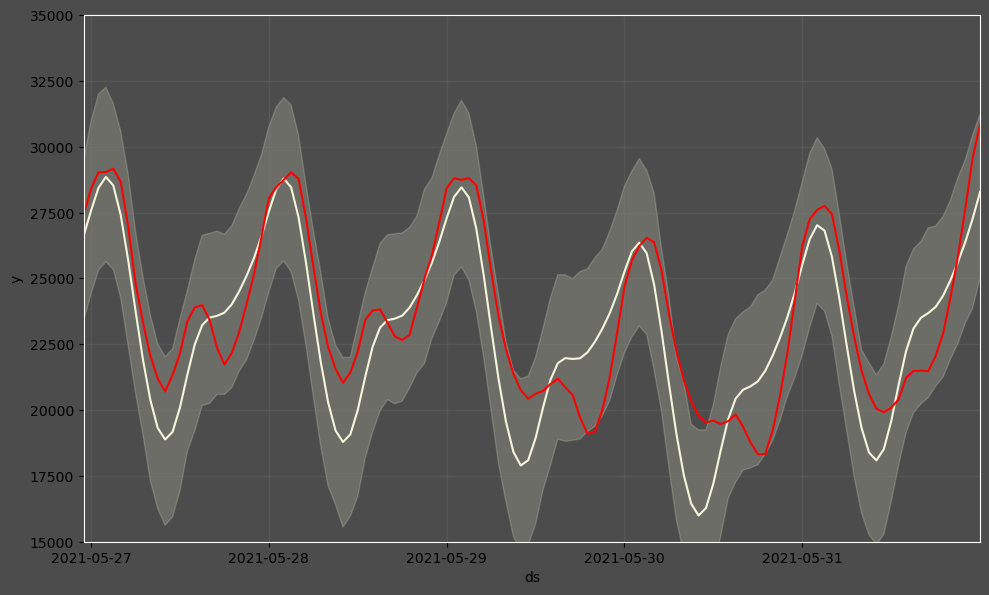

In [54]:

fig = prophet_plot(hourly_model, hourly_prediction_obj, line_color='beige')
ax = fig.gca()
fig.patch.set_facecolor('#4C4C4C')
ax.set_facecolor('#4C4C4C')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.yaxis.label.set_color('black')
ax.xaxis.label.set_color('black')
plt.axvline(x = hourly_test_data.iloc[0,0], color = 'r')
plt.plot(hourly_test_data['ds'], hourly_test_data['y'], c='r')
plt.xlim(hourly_test_data.iloc[0,0], np.datetime64('2021-05-31 23:59'))
plt.ylim(15000, 35000)

# Model training (5 minute)

In [6]:
# The data are in order, so we can do an 80/20 split on a particular time

train_data = data.iloc[:int(0.8 * data.shape[0])]
test_data = data.iloc[int(0.8 * data.shape[0]):]

### Simple model, no tuning

This is what happens when we run prophet with no tuning steps.

In [7]:
my_model = Prophet()
my_model.fit(train_data)

16:07:31 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
prediction_obj = my_model.predict(test_data)

In [50]:
test_data.iloc[0]

ds    2021-05-26 07:05:00
y                23836.42
Name: 670754, dtype: object

In [79]:
prediction_obj.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [82]:
prediction_obj['yhat']

0         21727.512797
1         21814.397205
2         21898.313833
3         21979.116251
4         22056.673706
              ...     
167647    19408.903143
167648    19260.864785
167649    19115.530093
167650    18972.970245
167651    18833.247042
Name: yhat, Length: 167652, dtype: float64

In [81]:
test_data

,ds,y
670754,2021-05-26 07:05:00,23836.42
670689,2021-05-26 07:10:00,23882.98
670641,2021-05-26 07:15:00,23877.29
670642,2021-05-26 07:20:00,23911.28
670806,2021-05-26 07:25:00,23922.86
...,...,...
838049,2022-12-31 23:35:00,20993.08
838194,2022-12-31 23:40:00,20941.46
838104,2022-12-31 23:45:00,20734.96
838105,2022-12-31 23:50:00,20673.72


## Model Evaluation

In [14]:
# define some useful metrics

def rmse(preds, y):
    return np.sqrt(np.mean((preds - y)**2))

def mse(preds, y):
    return np.mean((preds - y)**2)

def mape(preds, y):
    return np.mean(np.abs(np.divide(preds - y, y, out=np.zeros_like(y), where=y!=0)))

In [83]:
mape(prediction_obj['yhat'].to_numpy(), test_data['y'].to_numpy())

0.08856276180016523

In [86]:
rmse(prediction_obj['yhat'].to_numpy(), test_data['y'].to_numpy())

2804.176487239049

In [3]:
mape(final_preds['yhat'], data['y'])

NameError: name 'final_preds' is not defined

(15000.0, 35000.0)

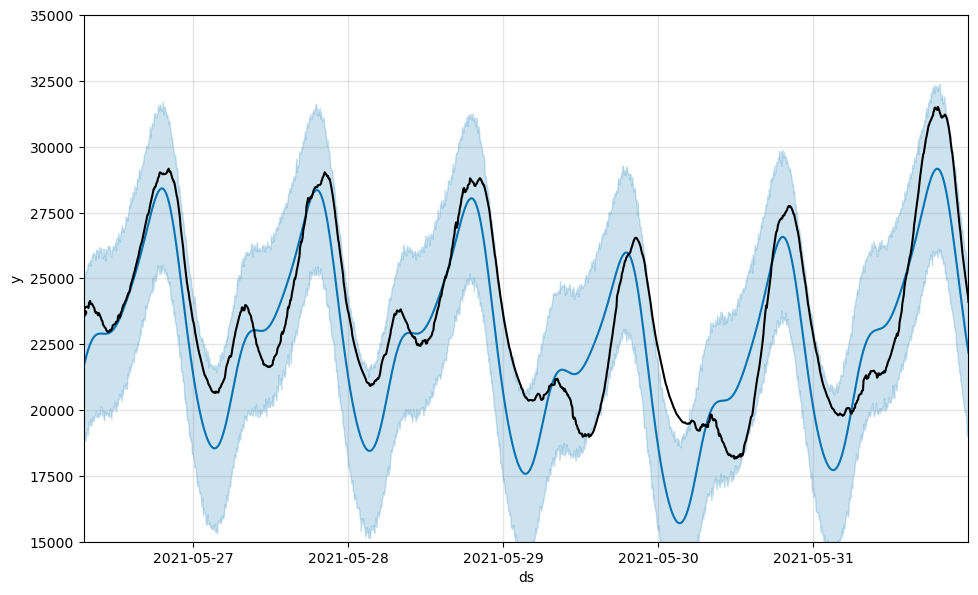

In [72]:
# plt.figure(figsize=(1, 200))
my_model.plot(prediction_obj)
plt.plot(test_data['ds'], test_data['y'], c='black')
plt.xlim(np.datetime64('2021-05-26 07:00'), np.datetime64('2021-05-31 23:59'))
plt.ylim(15000, 35000)

In [88]:
final_model = Prophet()
final_model.fit(data)

23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:28:22 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
final_preds = final_model.predict(data)
final_preds.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,25292.841268,18777.454803,25493.762189,25292.841268,25292.841268,-3011.742434,-3011.742434,-3011.742434,-1902.961741,...,954.821918,954.821918,954.821918,-2063.602610,-2063.602610,-2063.602610,0.0,0.0,0.0,22281.098834
1,2015-01-01 00:05:00,25292.886223,18873.126422,25213.858788,25292.886223,25292.886223,-3139.683576,-3139.683576,-3139.683576,-2030.487351,...,954.558499,954.558499,954.558499,-2063.754725,-2063.754725,-2063.754725,0.0,0.0,0.0,22153.202646
2,2015-01-01 00:10:00,25292.931178,18540.406881,24983.422695,25292.931178,25292.931178,-3264.971275,-3264.971275,-3264.971275,-2155.349375,...,954.284847,954.284847,954.284847,-2063.906747,-2063.906747,-2063.906747,0.0,0.0,0.0,22027.959903
3,2015-01-01 00:15:00,25292.976132,18471.514143,25125.388316,25292.976132,25292.976132,-3387.577396,-3387.577396,-3387.577396,-2277.519716,...,954.000996,954.000996,954.000996,-2064.058676,-2064.058676,-2064.058676,0.0,0.0,0.0,21905.398736
4,2015-01-01 00:20:00,25293.021087,18231.104472,24604.527418,25293.021087,25293.021087,-3507.478378,-3507.478378,-3507.478378,-2396.974846,...,953.706979,953.706979,953.706979,-2064.210511,-2064.210511,-2064.210511,0.0,0.0,0.0,21785.542709


In [92]:
final_preds[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("../predictions/prophet_preds.csv")